# Solutions 3 - Examples in Singular Value Decomposition

## Assignment 1

All functions from previous notebooks are collected in the file `ModuleB.jl` which contains the module `ModuleB`. 

In [1]:
include("./ModuleB.jl")
using .ModuleB

## Assignment 2

You can see the availabe images at http://timholy.github.io/TestImages.jl/.

After installing the package with `Pkg.add("TestImages")`, the images are located in the directory `.julia/packages/TestImages/..../images`.

In [2]:
# import Pkg; Pkg.add("TestImages")

In [3]:
using TestImages, Images

In [4]:
varinfo(TestImages)

| name       |      size | summary           |
|:---------- | ---------:|:----------------- |
| TestImages | 8.344 KiB | Module            |
| testimage  |   0 bytes | typeof(testimage) |


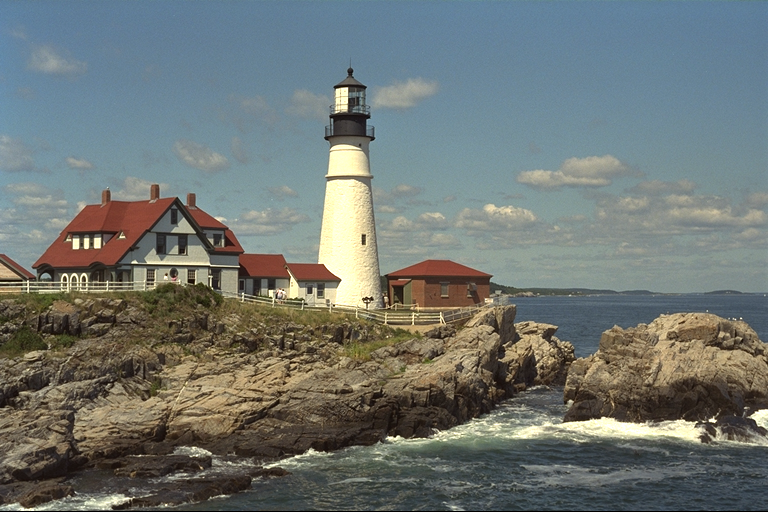

In [5]:
img=testimage("lighthouse")

In [6]:
# For example
img[1,1]

In [7]:
show(img[1,1])

RGB{N0f8}(0.361,0.486,0.6)

In [8]:
# Separate the image into R, G and B components
channels=channelview(img)

3×512×768 reinterpret(N0f8, ::Array{RGB{N0f8},3}):
[:, :, 1] =
 0.361  0.361  0.376  0.365  0.365  0.369  …  0.663  0.702  0.459  0.443  0.0
 0.486  0.486  0.514  0.498  0.498  0.502     0.682  0.745  0.486  0.467  0.0
 0.6    0.6    0.624  0.62   0.627  0.635     0.627  0.678  0.447  0.439  0.0

[:, :, 2] =
 0.349  0.361  0.353  0.369  0.376  0.376  …  0.745  0.678  0.427  0.443  0.0
 0.475  0.498  0.49   0.506  0.51   0.51      0.776  0.722  0.467  0.467  0.0
 0.588  0.608  0.608  0.624  0.639  0.631     0.725  0.667  0.424  0.439  0.0

[:, :, 3] =
 0.345  0.361  0.361  0.365  0.361  0.365  …  0.843  0.616  0.514  0.486  0.0
 0.478  0.494  0.494  0.498  0.494  0.498     0.871  0.655  0.553  0.525  0.0
 0.588  0.616  0.616  0.62   0.616  0.62      0.82   0.612  0.518  0.49   0.0

...

[:, :, 766] =
 0.329  0.357  0.357  0.349  0.361  0.357  …  0.208  0.259  0.192  0.173  0.0
 0.463  0.486  0.482  0.475  0.486  0.482     0.255  0.31   0.231  0.204  0.0
 0.518  0.569  0.596  0.588  0.6 

In [9]:
R=channels[1,:,:]
G=channels[2,:,:]
B=channels[3,:,:]

512×768 Array{N0f8,2} with eltype Normed{UInt8,8}:
 0.6    0.588  0.588  0.624  0.616  …  0.537  0.525  0.518  0.525  0.529
 0.6    0.608  0.616  0.608  0.608     0.557  0.576  0.569  0.565  0.58 
 0.624  0.608  0.616  0.616  0.616     0.592  0.588  0.596  0.596  0.608
 0.62   0.624  0.62   0.616  0.608     0.58   0.576  0.588  0.6    0.588
 0.627  0.639  0.616  0.62   0.62      0.596  0.592  0.6    0.608  0.596
 0.635  0.631  0.62   0.62   0.624  …  0.596  0.596  0.596  0.612  0.612
 0.635  0.62   0.624  0.62   0.62      0.596  0.592  0.6    0.608  0.612
 0.635  0.62   0.608  0.624  0.62      0.596  0.6    0.6    0.588  0.616
 0.627  0.631  0.631  0.624  0.624     0.596  0.6    0.6    0.596  0.604
 0.62   0.631  0.627  0.643  0.624     0.608  0.616  0.604  0.596  0.604
 0.643  0.631  0.624  0.635  0.631  …  0.592  0.608  0.608  0.596  0.592
 0.659  0.624  0.624  0.635  0.635     0.596  0.592  0.592  0.596  0.608
 0.643  0.651  0.639  0.635  0.631     0.592  0.604  0.588  0.6    0.624


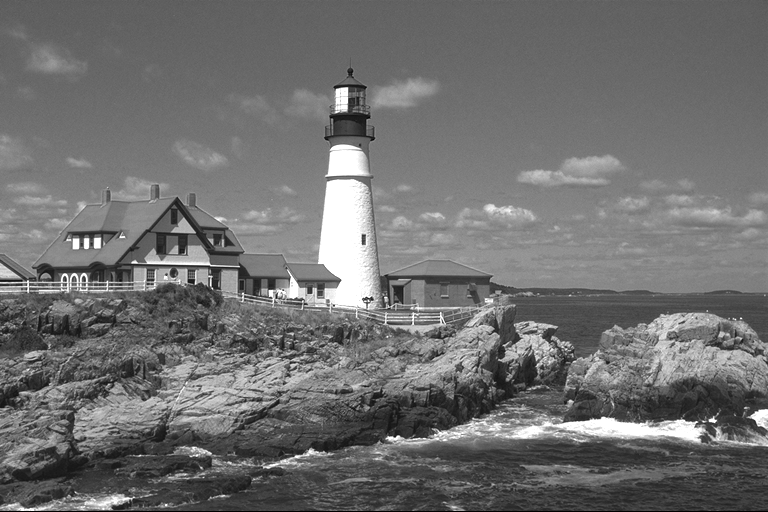

In [10]:
# Let us take a look at the red component
colorview(Gray,R)

In [11]:
using LinearAlgebra

In [12]:
# Compute the SVD of each component
UR,σR,VR=svd(R)
UG,σG,VG=svd(G)
UB,σB,VB=svd(B);

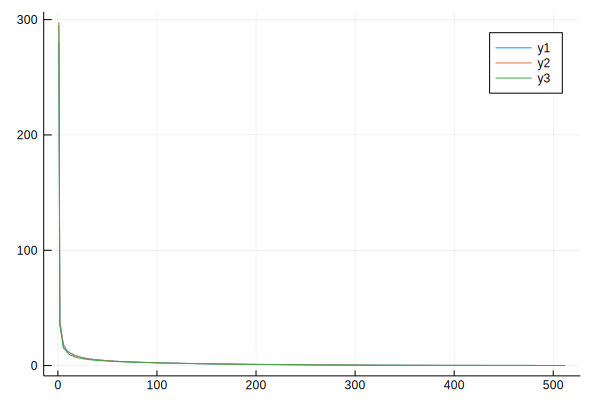

In [13]:
# Plot the singular values
using Plots
x=collect(1:minimum(size(img)))
plot(x,[σR σG σB])

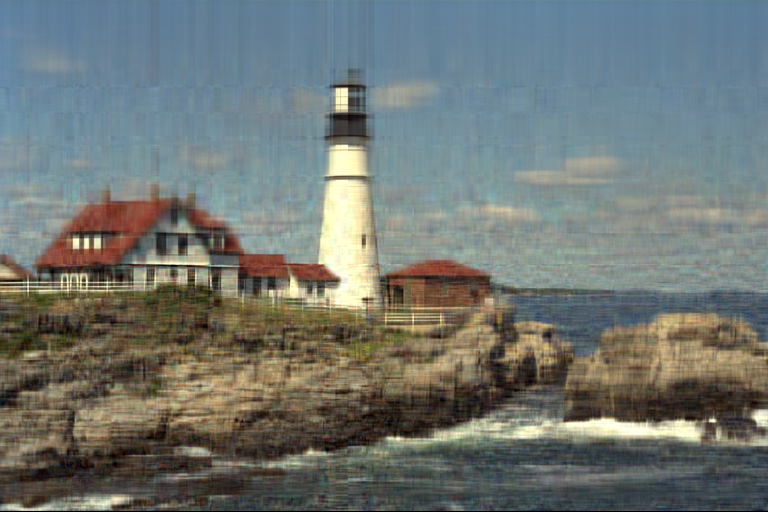

In [14]:
# Watch the compression quality
k=30
Rc=UR[:,1:k]*Diagonal(σR[1:k])*VR[:,1:k]'
Gc=UG[:,1:k]*Diagonal(σG[1:k])*VG[:,1:k]'
Bc=UB[:,1:k]*Diagonal(σB[1:k])*VB[:,1:k]'
colorview(RGB, Rc, Gc, Bc)

## Assignment 3

In [15]:
# Part of the preamble of lapack.jl
const liblapack = Base.liblapack_name
import LinearAlgebra.BLAS.@blasfunc
# import ..LinAlg: BlasFloat, Char, BlasInt, LAPACKException,
    # DimensionMismatch, SingularException, PosDefException, chkstride1, chksquare
import LinearAlgebra.BlasInt
function chklapackerror(ret::BlasInt)
    if ret == 0
        return
    elseif ret < 0
        throw(ArgumentError("invalid argument #$(-ret) to LAPACK call"))
    else # ret > 0
        throw(LAPACKException(ret))
    end
end

chklapackerror (generic function with 1 method)

In [16]:
for (gesvj, elty) in
    ((:dgesvj_,:Float64),
    (:sgesvj_,:Float32))
    @eval begin
        function gesvj!(A::Array{$elty})
            joba='G'
            jobu='U'
            jobv='V'
            m,n = size(A)
            lda=m
            sva=Array{$elty}(undef,n)
            mv=1
            V=Array{$elty}(undef,n,n)
            ldv=n
            lwork=max(6,m+n)
            work = Array{$elty}(undef,lwork)
            info = Array{BlasInt}(undef,1)
            ccall((@blasfunc($gesvj), liblapack), Cvoid,
            (Ref{UInt8}, Ref{UInt8}, Ref{UInt8}, 
            Ref{BlasInt}, Ref{BlasInt}, Ptr{$elty},
            Ref{BlasInt}, Ptr{$elty}, Ref{BlasInt},
            Ptr{$elty}, Ref{BlasInt}, Ptr{$elty},
            Ref{BlasInt}, Ref{BlasInt}),
                joba, jobu, jobv, 
                m, n, A, 
                lda, sva, mv,
                V, ldv, work, 
                lwork, info)
                chklapackerror(info[])
            A, sva, V
        end
    end
end

In [17]:
# Small, strongly scaled matrix
m=20
n=15
using Random
Random.seed!(421)
B=rand(m,n)
D=exp.(80*(rand(n).-0.5))
A=B*Diagonal(D);

In [18]:
U,σ,V=ModuleB.myJacobiR(A)
U₁,σ₁,V₁=gesvj!(copy(A))
(sort(σ,rev=true)-σ₁)./σ₁

15-element Array{Float64,1}:
  4.268401770476411e-16 
  6.078735165862111e-16 
  5.621953385178811e-16 
  5.422078468025897e-16 
  4.937338474602337e-16 
  2.654059021360239e-16 
  1.0452054006950505e-15
  5.417485920556403e-16 
  4.834325068703124e-16 
  6.664460448973878e-16 
  5.623499103704912e-16 
  3.526050739825378e-16 
 -6.571825807079988e-16 
  0.0                   
  0.0                   

In [19]:
# Timing for large matrices
n=1000
A=rand(n,n)
@time svd(A);
@time gesvj!(A);

  0.994124 seconds (214.04 k allocations: 57.054 MiB, 3.74% gc time)
  4.930926 seconds (10 allocations: 7.653 MiB)
